# Statistics in Python: ANOVAs

March. 18, 2019 (Strongway)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/strongway/tutorial_data_science/blob/master/anovas.ipynb)

The analysis of variance (ANOVA) is an important statistical tool for psychology analysis. In Python we have `statsmodels` to do this job. `statsmodels` is a Python module that provides classes and functiosn for the estimation of many different statistical models, as well as for conducting statitical tests, and statistical data exploration. The online documentation is hosted at [statsmodels.org](http://statsmodels.org). 


`statsmodels` has two ANOVAs: `anova_lm` for ANOVA with a linear OLSModel, and `AnovaRM` for repeated measures ANOVA. 

## 1. Installation of `statsmodels`

To obtain the latest version of statsmodels using `pip`

> pip install -U statsmodels

Or use Anaconda

> conda install -c conda-forge statsmodels

Note on google Colab, `statsmodels` v0.8 has already been install. 

In [103]:
# import modules and functions 
import numpy as np
import pandas as pd
import altair as alt
import scipy.stats as ss
from statsmodels.stats.anova import AnovaRM


## 2. Repeated measures ANOVA

We first check the syntax of `AnovaRM`.

In [3]:
help(AnovaRM)

Help on class AnovaRM in module statsmodels.stats.anova:

class AnovaRM(builtins.object)
 |  Repeated measures Anova using least squares regression
 |  
 |  The full model regression residual sum of squares is
 |  used to compare with the reduced model for calculating the
 |  within-subject effect sum of squares [1].
 |  
 |  Currently, only fully balanced within-subject designs are supported.
 |  Calculation of between-subject effects and corrections for violation of
 |  sphericity are not yet implemented.
 |  
 |  Parameters
 |  ----------
 |  data : DataFrame
 |  depvar : string
 |      The dependent variable in `data`
 |  subject : string
 |      Specify the subject id
 |  within : a list of string(s)
 |      The within-subject factors
 |  between : a list of string(s)
 |      The between-subject factors, this is not yet implemented
 |  aggregate_func : None, 'mean', or function
 |      If the data set contains more than a single observation per subject
 |      and cell of the spec

## 3. Statistical test with a real example

### 3.1 Load experimental data

We use a visual search study (Shi et al., 2019) as an example. The data are available at 
https://github.com/msenselab/visualsearch. The first experiment was a replication of Horowitz & Wolfe (1998), a standard T vs Ls static search and a dynamic search (the display was randomly reshuffled every 110 ms). There were three set sizes (8, 12, 16). 


In [105]:
# read raw data

raw = pd.read_csv('https://raw.githubusercontent.com/msenselab/visualsearch/master/data/exp1.csv')
raw.head()

,target,setsize,dyn,resp,rt,sub,exp,correct
0,Absent,12,Static,2,2.583007,1,1,1
1,Absent,8,Static,2,0.935967,1,1,1
2,Present,16,Static,1,0.794771,1,1,1
3,Present,8,Static,1,1.241838,1,1,1
4,Absent,12,Static,2,1.759485,1,1,1


In [129]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9620 entries, 0 to 9619
Data columns (total 8 columns):
target     9620 non-null object
setsize    9620 non-null int64
dyn        9620 non-null object
resp       9620 non-null int64
rt         9620 non-null float64
sub        9620 non-null int64
exp        9620 non-null int64
correct    9620 non-null object
dtypes: float64(1), int64(4), object(3)
memory usage: 601.3+ KB


For this tutorial, we skip error analysis and other preprocessing. We will use chain rules to quickly obtain the mean RTs, preparing average data for further statistics. 

### 3.2. Summarise the data

Recall the chain rules, and think about how to apply chain rules to manipulate/summarize the data. If you want to see the reference, here is the link to our previous tutorial - [Python_4_r_users](https://colab.research.google.com/github/strongway/tutorial_data_science/blob/master/python_4_r_users.ipynb) Or [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/strongway/tutorial_data_science/blob/master/python_4_r_users.ipynb). 

In [126]:
# obtain valid mean RTs
# note: I use () to have multiple lines without using \ at end of each line.
mRTs = (raw.query("correct == '1' ").
        groupby(['sub','dyn','target', 'setsize']).
        agg({"resp":"count", "rt":"mean"}))
mRTs.head()

resp        rt
sub dyn     target  setsize                
1   Dynamic Absent  8          35  2.566563
                    12         34  3.101724
                    16         32  2.898478
            Present 8          34  1.118311
                    12         35  1.218653

You may wonder why I used '1' instead of number 1 (I wondered as well!), you can first check the table column types. Soon you will realize that that column contains strings. 

In [19]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9620 entries, 0 to 9619
Data columns (total 8 columns):
target     9620 non-null object
setsize    9620 non-null int64
dyn        9620 non-null object
resp       9620 non-null int64
rt         9620 non-null float64
sub        9620 non-null int64
exp        9620 non-null int64
correct    9620 non-null object
dtypes: float64(1), int64(4), object(3)
memory usage: 601.3+ KB


In [20]:
raw.correct.unique()

array(['1', '0', 'True', 'False'], dtype=object)

Anyway, let's get back to the mean RT data for further visualization and analysis. To get some intuitive of the data, let's first visualize the mean RTs. 

In [117]:
# get grand mean RTs
mmRTs = (mRTs.groupby(['dyn','target', 'setsize']).
        agg({"rt":[np.mean, ss.sem]}))
mmRTs.head()


rt          
                             mean       sem
dyn     target  setsize                    
Dynamic Absent  8        2.208454  0.267384
                12       2.262694  0.321961
                16       2.495611  0.284776
        Present 8        1.178920  0.114543
                12       1.234546  0.145360

Note, the above table is a MultiIndex table.  You can flatten it by appending `.reset_index()`. MultiIndex table offers one great conveninent - stacking and unstacking. For example:

In [118]:
mmRTs.unstack(level = 2)

rt                                                  
                     mean                           sem                    
setsize                8         12        16        8         12        16
dyn     target                                                             
Dynamic Absent   2.208454  2.262694  2.495611  0.267384  0.321961  0.284776
        Present  1.178920  1.234546  1.415677  0.114543  0.145360  0.140737
Static  Absent   1.177113  1.554864  1.788847  0.078252  0.113560  0.157800
        Present  0.771285  0.898985  0.945592  0.034035  0.044600  0.033591

In [120]:
# first split column 'rt', and reset index
mmRTs0 = pd.DataFrame(mmRTs.rt).reset_index()
mmRTs0

,dyn,target,setsize,mean,sem
0,Dynamic,Absent,8,2.208454,0.267384
1,Dynamic,Absent,12,2.262694,0.321961
2,Dynamic,Absent,16,2.495611,0.284776
3,Dynamic,Present,8,1.178920,0.114543
4,Dynamic,Present,12,1.234546,0.145360
5,Dynamic,Present,16,1.415677,0.140737
6,Static,Absent,8,1.177113,0.078252
7,Static,Absent,12,1.554864,0.113560
8,Static,Absent,16,1.788847,0.157800
9,Static,Present,8,0.771285,0.034035


### 3.3 Visualize the data

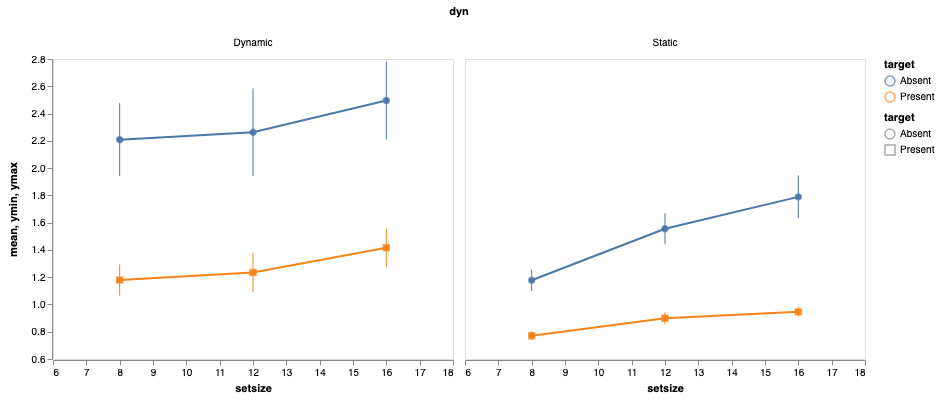

In [122]:
# Important note on multiple facet charts with multiple layers. DO NOT specify data in base plot!
base = alt.Chart().encode(
    alt.X('setsize', scale = alt.Scale( domain = (6,18))),
    alt.Y('mean', scale = alt.Scale(zero = False)),
    color = 'target',
    shape ='target'
)

chart = base.mark_point() + base.mark_line()
chart += base.mark_rule().encode(
    x = "setsize",
    y = "ymin:Q",
    y2 = "ymax:Q",
    size = 2
).transform_calculate(
    ymin = 'datum.mean - datum.sem',
    ymax = 'datum.mean + datum.sem'
)

chart.facet(column = 'dyn', data = mmRTs0).configure_axis(
    grid = False
)

Visualization using Matplotlib functions (matlab style). When you use matplotlib, multiindex table is useful for selecting subset of data. 

__MultiIndex subsecting data__

> data.loc['index1','index2']

In [209]:
# e.g., select dynamic target-present mean RTs
mmRTs.loc['Dynamic','Present'].rt['mean']

setsize
8     1.178920
12    1.234546
16    1.415677
Name: mean, dtype: float64

In addition, you can get the unique of the levels from multiIndex by using `.index.levels[]`

In [212]:
# For example, get dyn levels
mmRTs.index.levels[0]

Index(['Dynamic', 'Static'], dtype='object', name='dyn')

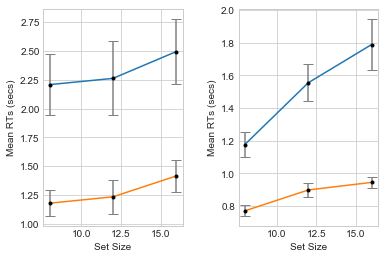

In [220]:
# Now let's visualize using standard matplotlib functions
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
i = 1
for dyn in mmRTs.index.levels[0]:
    ax = fig.add_subplot(1,2,i)
    i += 1
    for tar in mmRTs.index.levels[1]:
        cdat = mmRTs.loc[dyn,tar]
        ax.plot(cdat.index, cdat.rt['mean'])
        ax.errorbar(cdat.index, cdat.rt['mean'],yerr = cdat.rt['sem'], fmt = '.k', ecolor = 'gray', capsize = 5)
        ax.set(xlabel = 'Set Size', ylabel ='Mean RTs (secs)')
        

### 3.5 Repeated ANOVA test

In this example, we have three factors: Search type (Dynamic vs Static), Target (Absent vs. Present), and Set size (8, 12, 16). As we saw from the help of AnovaRM, it accepts parameters: data, depvar, subject, within, between, and aggregate_func. We have already aggregate mean RTs. So we only need to provide the first parameters. 


In [131]:
mRTs0 = mRTs.reset_index() 
avr = AnovaRM(mRTs0, 'rt','sub', within = ['dyn','target','setsize'])
res = avr.fit()
print(res)

                     Anova
                   Num DF  Den DF F Value Pr > F
------------------------------------------------
dyn                1.0000 10.0000 19.0085 0.0014
target             1.0000 10.0000 45.5424 0.0001
setsize            2.0000 20.0000 52.6811 0.0000
dyn:target         1.0000 10.0000  9.8088 0.0107
dyn:setsize        2.0000 20.0000  3.3114 0.0572
target:setsize     2.0000 20.0000 12.9475 0.0002
dyn:target:setsize 2.0000 20.0000  6.4267 0.0070



## 4. ANOVA analysis with a linear OLSModel

`Statsmodels` provides ordinary least squares, which is a method for estimating the parameters in a linear regression model. The `ols` from `Statsmodels` now accepts R-style formulas with pandas data frames to fit your models. `ols` comes from `statsmodels.formula.api`. The following is an example from `Statsmodels` official website:


In [134]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
dat = sm.datasets.get_rdataset("Guerry","HistData").data
# Fit regression model (using the natural log of one of the regressors)
results = smf.ols('Lottery ~ Literacy + np.log(Pop1831)', data=dat).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                Lottery   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     22.20
Date:                Mon, 18 Mar 2019   Prob (F-statistic):           1.90e-08
Time:                        23:03:32   Log-Likelihood:                -379.82
No. Observations:                  86   AIC:                             765.6
Df Residuals:                      83   BIC:                             773.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         246.4341     35.233     

In [153]:
lm = smf.ols('rt ~ C(target)*C(dyn)*setsize', data = mRTs0).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     rt   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     20.20
Date:                Mon, 18 Mar 2019   Prob (F-statistic):           6.75e-18
Time:                        23:26:18   Log-Likelihood:                -104.22
No. Observations:                 132   AIC:                             224.4
Df Residuals:                     124   BIC:                             247.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                         1.9486      0.364      5.346      0.000       1.227       2.670
C(target)[T.Present]                             -0.9995      0.515     -1.939      0.055      -2.020       0.021
C(dyn)[T.Static]                                 -1.3593      0.515     -2.637      0.009      -2.379      -0.339
C(target)[T.Present]:C(dyn)[T.Static]             1.0206      0.729      1.400      0.164      -0.422       2.463
setsize                                           0.0359      0.029      1.225      0.223      -0.022       0.094
C(target)[T.Present]:setsize                     -0.0063      0.041     -0.152      0.879      -0.088       0.076
C(dyn)[T.Static]:setsize                          0.0406      0.041      0.979      0.330      -0.041       0.123
C(target)[T.Present]:C(dyn)[T.Static]:setsize    -0.0484      0.059     -0.825      0.411      -0.164       0.068
==============================================================================
Omnibus:                       14.347   Durbin-Watson:                   0.508
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               38.967
Skew:                           0.276   Prob(JB):                     3.46e-09
Kurtosis:                       5.604   Cond. No.                         327.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [146]:
from statsmodels.stats.api import anova_lm
aov_res = anova_lm(lm)
print(aov_res)

              df     sum_sq    mean_sq          F        PR(>F)
C(target)    1.0  24.125078  24.125078  77.759117  7.242848e-15
C(dyn)       1.0  14.043969  14.043969  45.266034  5.173061e-10
setsize      1.0   2.359477   2.359477   7.604984  6.672907e-03
Residual   128.0  39.712514   0.310254        NaN           NaN


In [152]:
mlm = smf.mixedlm('rt ~ C(target)*setsize+C(dyn)', mRTs0, groups = mRTs0['sub']).fit()
mlm.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:                   MixedLM      Dependent Variable:      rt      
No. Observations:        132          Method:                  REML    
No. Groups:              11           Scale:                   0.1509  
Min. group size:         12           Likelihood:              -85.9403
Max. group size:         12           Converged:               Yes     
Mean group size:         12.0                                          
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     1.595    0.223  7.162 0.000  1.159  2.032
C(target)[T.Present]         -0.489    0.257 -1.900 0.057 -0.994  0.015
C(dyn)[T.Static]             -0.652    0.068 -9.648 0.000 -0.785 -0.520
setsize                       0.056    0.015  3.838 0.000  0.027  0.085
C(target)[T.Present]:setsize -0.030    0.021 -1.473 0.141 -0.071  0.010
Group Var                     0.169    0.217                           
=======================================================================

"""

## 5. References and resources

1. [Official website of statsmodels](http://www.statsmodels.org)
2. [Examples](https://github.com/statsmodels/statsmodels/wiki/Examples#linear-mixed-models)
